<a href="https://colab.research.google.com/github/thingumajig/extractive_summary/blob/master/extractive_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# init

In [1]:
# %%capture
# !pip uninstall --quiet --yes tensorflow
# !pip install tensorflow-gpu==1.14.0

# !pip install tensorflow_text

!pip install --upgrade tensorflow-gpu
!pip install tensorflow-hub
!pip install tensorflow-text
!pip install scikit-learn
!pip install spacy
# !pip install sentencepiece==0.1.83
# !pip install tf-sentencepiece==0.1.83

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [1]:
## important import!!
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer

import sys

src_path = 'extractive_summary'  

!test -d $src_path || git clone https://github.com/thingumajig/$src_path $src_path
%cd /content/$src_path
!git pull
%cd /content

if not src_path in sys.path:
  sys.path.insert(0, src_path)

# print(sys.path)

/content/extractive_summary
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/thingumajig/extractive_summary
   135762e..d7cc731  master     -> origin/master
Updating 135762e..d7cc731
Fast-forward
 extractive_summary.py | 2 +-
 spacy_driver.py       | 4 +---
 tfhubutils2.py        | 1 -
 3 files changed, 2 insertions(+), 5 deletions(-)
/content


In [18]:
# !pip install en_core_web_sm==2.2.5
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Extractive summary


In [2]:
from extractive_summary import ExtractiveSummary, create_extractive_summary_gen
es = create_extractive_summary_gen()


Default GPU Device: /device:GPU:0
initialize model.
initialize model.
initialize model.


In [0]:
#@title Text


text = " The House Judiciary Committee's vote Friday passing articles of impeachment against President Donald Trump was meant as extraordinary repudiation. The history was certainly there, and is weighing on the President. But it did not appear anyone felt rebuked at the White House. Minutes before the party-line vote was called, the man joining Trump at the center of the scandal -- his personal attorney Rudy Giuliani -- was seen ambling across the White House driveway toward the West Wing. \"Maybe he's here to go to the Christmas party with his son, who works at the White House,\" offered Kellyanne Conway, the President's counselor, when asked about Giuliani's presence. The party, according to the White House schedule, was set to begin at 8:15 p.m., a full 10-and-a-half hours after Giuliani arrived." #@param {type:"string"}


In [31]:
from spacy_driver import SpacyDocExtra
from sklearn.cluster import Birch
from scipy.spatial import distance

from collections import defaultdict
import numpy as np

extradoc = SpacyDocExtra(text, parser=es.parser, embedder=es.embedder)

n_clusters = None
min_cluster_elements = 2

bm = Birch(threshold=0.71, n_clusters=n_clusters)

bm.fit(extradoc.embeddings)

labels = bm.labels_
print(f'labels: {labels} ({len(labels)})')
centroids = bm.subcluster_centers_
print(f'centroids:  {len(centroids)} ')
n_clusters = np.unique(labels).size

print(f'n_clusters:{n_clusters}')

clusters = defaultdict(list)
for i, key in enumerate(labels):
  clusters[key].append(i)

import pprint
pp = pprint.PrettyPrinter(indent=4, width=60, compact=True)
pp.pprint(clusters)


selected_clusters = list(filter(lambda elem: len(elem[1]) >= min_cluster_elements, clusters.items()))
selected_clusters = list(sorted(selected_clusters, key=lambda elem: len(elem[1]),reverse=True))

pp.pprint(selected_clusters)

labels: [0 0 1 2 3 2 2] (7)
centroids:  4 
n_clusters:4
defaultdict(<class 'list'>,
            {   0: [0, 1],
                1: [2],
                2: [3, 5, 6],
                3: [4]})
[(2, [3, 5, 6]), (0, [0, 1])]


In [56]:
max_naming_len = 60
name_candidates_dict = es.collect_keyphrases(extradoc.doc, max_naming_len = max_naming_len)
pp.pprint(name_candidates_dict.keys())

dict_keys(['the White House schedule', 'his son , who works at the White House', 'The history', 'articles of impeachment against President Donald Trump', 'the scandal', 'the West Wing', 'The party', 'Giuliani', 'the White House', 'the party - line vote', 'it', 'extraordinary repudiation', 'the White House driveway', 'who', 'the center of the scandal', "Giuliani 's presence", "Kellyanne Conway , the President 's counselor", 'the President', 'impeachment against President Donald Trump', '8:15 p.m.', 'the Christmas party', 'anyone', 'Trump', 'President Donald Trump', 'he'])


In [44]:
from nltk_tree import print_tree

for token in extradoc.doc:
    # print(f'{token.text}\t{token.lemma_}\t{token.pos_}\t{token.dep_}:{token.dep}')
    s = ''
    cc = 0
    for t in token.subtree:
      s += str(t)+' '
      cc +=1
    # if cc>1:
    print(f'[{token.dep_}-{token.dep}-{token.pos_}--{token.text}]\t{s}')
    if token.n_lefts + token.n_rights > 0:
      print_tree(token)

[-0-SPACE-- ]	  
[det-415-DET--The]	  The 
The-det
   |    
    -  

[compound-7037928807040764755-PROPN--House]	House 
[compound-7037928807040764755-PROPN--Judiciary]	Judiciary 
[poss-440-PROPN--Committee]	  The House Judiciary Committee 's 
                Committee-poss                 
       _______________|____________________     
      |               |            |    The-det
      |               |            |       |    
House-compound Judiciary-compou 's-case     -  
                      nd                       

[case-8110129090154140942-PART--'s]	's 
[nsubjpass-430-NOUN--vote]	  The House Judiciary Committee 's vote Friday passing articles of impeachment against President Donald Trump 
                                                vote-nsubjpass                                                          
        ______________________________________________|________________________________________                          
       |                              |      

In [57]:
minimum_sentence_len = 40
distance_threshold = 0.8

selected_texts = []
for s in selected_clusters:
  cluster_ix = s[0]
  centroid = centroids[cluster_ix]

  #Filter sentences
  l = []
  name_candidates = set()
  for ns in s[1]:
    sent = extradoc.sentences[ns]
    # sent = str(sent).strip()
    if len(sent) > minimum_sentence_len:
      l.append(sent)

    #Collect key phrases candidates
    ssent = extradoc.sentence_structs[ns]
    for spart in es.parser.iter_nps_str(ssent):
      if len(spart) <= max_naming_len:
        name_candidates.add(spart)

  if len(l) >= min_cluster_elements:
    name_candidates_list = []
    for name in name_candidates:
      emb = name_candidates_dict[name]
      d = distance.cosine(emb, centroid)
      if d<=distance_threshold:
        name_candidates_list.append((name, d))

    name_candidates_list = sorted(name_candidates_list, key=lambda x: x[1])

    selected_texts.append((cluster_ix, l, name_candidates_list))

pp.pprint(selected_texts)

[   (   2,
        [   'Minutes before the party-line vote was '
            'called, the man joining Trump at the center '
            'of the scandal -- his personal attorney Rudy '
            'Giuliani -- was seen ambling across the White '
            'House driveway toward the West Wing.',
            "Maybe he's here to go to the Christmas party "
            'with his son, who works at the White House," '
            "offered Kellyanne Conway, the President's "
            "counselor, when asked about Giuliani's "
            'presence.',
            'The party, according to the White House '
            'schedule, was set to begin at 8:15 p.m., a '
            'full 10-and-a-half hours after Giuliani '
            'arrived.'],
        [   ("Giuliani 's presence", 0.5524557708067896),
            ('Giuliani', 0.5852449010244506),
            (   'the White House schedule',
                0.5985244775540268),
            (   'his son , who works at the White House',
           

In [47]:
!pip install wordcloud
!pip install matplotlib

defaultdict(None,
            {   'Giuliani': 0.4147550989755494,
                "Giuliani 's presence": 0.44754422919321035,
                "Kellyanne Conway , the President 's counselor": 0.3791383755508889,
                'President Donald Trump': 0.36663238757775496,
                'The history': 0.2510102029637654,
                'articles of impeachment against President Donald Trump': 0.5250758695181635,
                'his son , who works at the White House': 0.39608068802448315,
                'impeachment against President Donald Trump': 0.48517626107919953,
                'the President': 0.3269030945761885,
                'the White House': 0.35308205266326476,
                'the White House driveway': 0.3692085059183129,
                'the White House schedule': 0.4014755224459732})


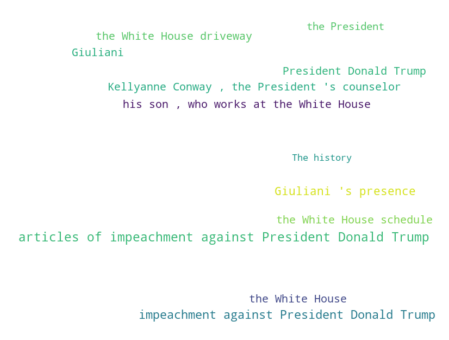

In [73]:
wcdict = defaultdict()

for e in selected_texts:
  for x in e[2]:
    wcdict[x[0]]=1-x[1]

pp.pprint(wcdict)
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color="white", width=800, height=600,
                      min_font_size=6,font_step=2 )
wordcloud.generate_from_frequencies(wcdict)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()